In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.utils.weight_norm as weight_norm
import torch.nn.functional as F
import numpy as np
import scipy as sp
from scipy.stats import norm
from scipy.stats import shapiro
import matplotlib.pyplot as plt


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load training set
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load test set
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Class labels
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

57.7%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [4]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, threshold=2, use_mask=True):
        super().__init__(in_features, out_features, bias)
        self.threshold = -torch.log10(torch.tensor(threshold))
        self.use_mask = use_mask
        self.entropy = None
        
    def wval(self, M):
        L = M.shape[1] if M.ndim == 2 else M.shape[1] * M.shape[2] * M.shape[3]
        alpha = torch.as_tensor(1/2, dtype=M.dtype, device=M.device)
        beta = torch.as_tensor((L-1)/2, dtype=M.dtype, device=M.device)
    
        # Normalize each weight vector going from a node in A to layer B
        M_normed = F.normalize(M, p=2, dim=1)
        
        M_clamped = torch.clamp(M_normed**2, min=1e-8, max=1-1e-8)
    
        # Compute the incomplete beta function manually using Beta distribution
        # This is done using a formula for the Beta CDF (this is a simple approximation)
        B = torch.exp(
            torch.lgamma(alpha + beta) - torch.lgamma(alpha) - torch.lgamma(beta)
        )  # Beta function normalization constant
        cdf = (M_clamped**(alpha - 1)) * ((1 - M_clamped)**(beta - 1)) / B
        beta_surv = 1 - cdf  # Survival function
        
        w_val = -torch.log10(beta_surv)
        assert w_val.shape == M.shape

        return w_val

    def forward(self, input):
        if self.use_mask:
            # Compute significance
            significance = self.wval(self.weight)
    
            # Create binary mask
            mask = (significance >= self.threshold).float()
    
            # Apply the mask (zero out insignificant weights)
            masked_weight = self.weight * mask
        else:
            masked_weight = self.weight

        flat_M = torch.flatten(masked_weight)
        flat_M_2 = flat_M.pow(2)
        self.entropy = sp.stats.entropy(flat_M_2.detach().numpy())
            
        return F.linear(input, masked_weight, self.bias)


# class FlexibleMLP(nn.Module):
#     def __init__(self, input_size=13, layer1=64, layer2=32, activation_fn=nn.ReLU, use_mask=True, threshold=2):
#         super().__init__()
#         # Instantiate activation function
#         self.activation = activation_fn()

#         # Build model
#         self.model = nn.Sequential(
#             MaskedLinear(input_size, layer1, threshold=threshold, use_mask=use_mask),
#             self.activation,
#             MaskedLinear(layer1, layer2, threshold=threshold, use_mask=use_mask),
#             self.activation,
#             MaskedLinear(layer2, 1, threshold=threshold, use_mask=use_mask)
#         )

#     def forward(self, x):
#         return self.model(x)



In [5]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU, use_mask=True):
        super(CNN, self).__init__()
        self.activation = activation_fn()
        self.use_mask = use_mask
        
        #CIFAR-10
        self.model = nn.Sequential(
            MaskedConv2d(3, 64, 3, padding=1, use_mask=self.use_mask),  # doubled from 32 to 64
            self.activation,
            nn.MaxPool2d(2, 2),

            MaskedConv2d(64, 128, 3, padding=1, use_mask=self.use_mask), # doubled from 64 to 128
            self.activation,
            nn.MaxPool2d(2, 2),

            nn.Flatten(),

            MaskedLinear(128 * 8 * 8 , 512, use_mask=self.use_mask), # doubled from 256 to 512
            self.activation,
            MaskedLinear(512, 10, use_mask=self.use_mask)
        )

    def forward(self, x):
        return self.model(x)


class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, bias=True, stride=1, padding=0, threshold=2, use_mask=True):
        super().__init__(in_channels, out_channels, kernel_size)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.threshold = -torch.log10(torch.tensor(threshold))
        self.use_mask = use_mask
        self.entropy = None
        
    def wval(self, M):
        L = M.shape[1] if M.ndim == 2 else M.shape[1] * M.shape[2] * M.shape[3]
        alpha = torch.as_tensor(1/2, dtype=M.dtype, device=M.device)
        beta = torch.as_tensor((L-1)/2, dtype=M.dtype, device=M.device)
    
        # Normalize each weight vector going from a node in A to layer B
        M_normed = F.normalize(M, p=2, dim=1)
        
        M_clamped = torch.clamp(M_normed**2, min=1e-8, max=1-1e-8)
    
        # Compute the incomplete beta function manually using Beta distribution
        # This is done using a formula for the Beta CDF (this is a simple approximation)
        B = torch.exp(
            torch.lgamma(alpha + beta) - torch.lgamma(alpha) - torch.lgamma(beta)
        )  # Beta function normalization constant
        cdf = (M_clamped**(alpha - 1)) * ((1 - M_clamped)**(beta - 1)) / B
        beta_surv = 1 - cdf  # Survival function
        
        w_val = -torch.log10(beta_surv)
        assert w_val.shape == M.shape

        return w_val

    def forward(self, input):
        # print(input.shape)
        if self.use_mask:
            # Compute significance
            significance = self.wval(self.weight)
    
            # Create binary mask
            mask = (significance >= self.threshold).float()
    
            # Apply the mask (zero out insignificant weights)
            masked_weight = self.weight * mask
        else:
            masked_weight = self.weight

        flat_M = torch.flatten(masked_weight)
        flat_M_2 = flat_M.pow(2)
        self.entropy = sp.stats.entropy(flat_M_2.detach().numpy())
            
        return F.conv2d(input, masked_weight, self.bias, stride=self.stride, padding=self.padding)


[use_mask=False, reg=None] Test Accuracy: 73.82%, Test Loss: 0.7953
[use_mask=False, reg=L1] Test Accuracy: 73.74%, Test Loss: 0.7705
[use_mask=True, reg=None] Test Accuracy: 68.21%, Test Loss: 0.9167
[use_mask=False, reg=None] Test Accuracy: 60.16%, Test Loss: 1.1270
[use_mask=False, reg=L1] Test Accuracy: 59.93%, Test Loss: 1.1439
[use_mask=True, reg=None] Test Accuracy: 44.76%, Test Loss: 1.5747


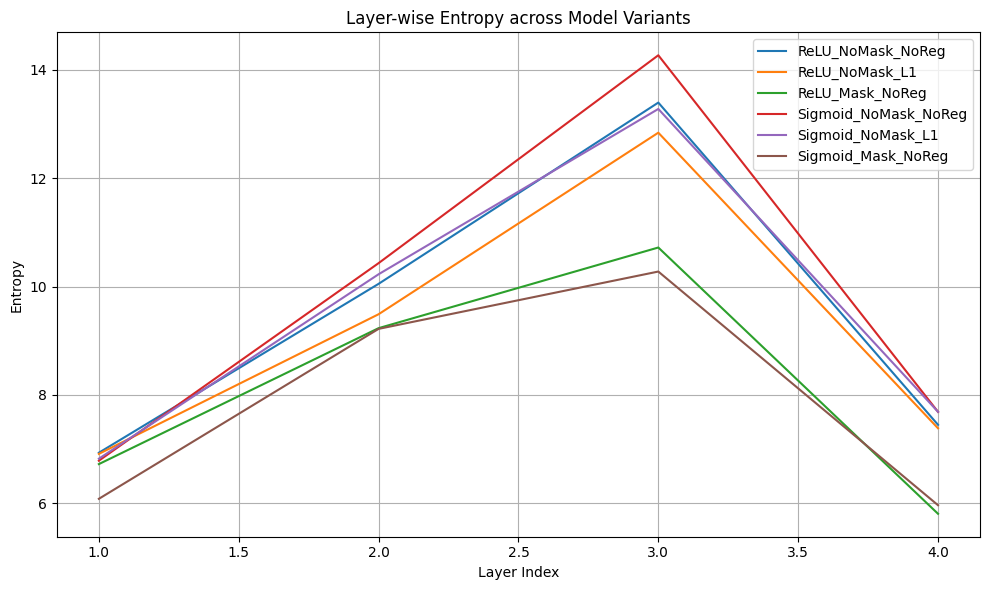

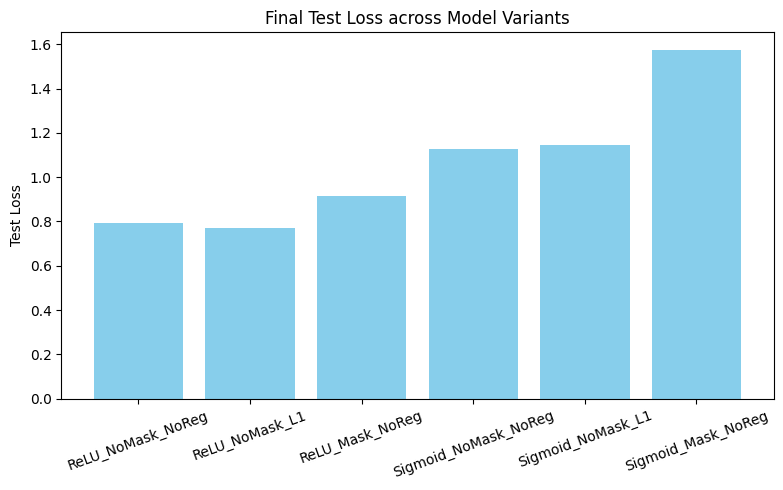

In [6]:
# Define your CNN model class beforehand: CNN(nn.ReLU, use_mask=...) with an 'entropy' attribute per layer

def train_and_collect_metrics(act, use_mask, regularization=None, lambda_reg=0.0):
    model = CNN(act, use_mask=use_mask).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 4

    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader, 0):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)

            if regularization == "L1" and lambda_reg > 0:
                reg_term = sum(p.abs().sum() for p in model.parameters())
                loss += lambda_reg * reg_term
            elif regularization == "L2" and lambda_reg > 0:
                reg_term = sum((p ** 2).sum() for p in model.parameters())
                loss += lambda_reg * reg_term

            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"[use_mask={use_mask}, reg={regularization}] Test Accuracy: {accuracy:.2f}%, Test Loss: {test_loss:.4f}")

    # Collect entropies
    entropies = []
    for name, layer in model.named_modules():
        if isinstance(layer, (nn.Conv2d, MaskedLinear, nn.Linear, MaskedConv2d)):
            entropies.append(layer.entropy)  # assumes .entropy attribute exists
    return entropies, test_loss

# Run all configurations
entropy_results = {}
test_losses = {}
configs = [
    ("ReLU_NoMask_NoReg", nn.ReLU, False, None, 0.0),
    ("ReLU_NoMask_L1", nn.ReLU, False, "L1", 1e-6),
    ("ReLU_Mask_NoReg", nn.ReLU, True, None, 0.0),
    ("Sigmoid_NoMask_NoReg", nn.Sigmoid, False, None, 0.0),
    ("Sigmoid_NoMask_L1", nn.Sigmoid, False, "L1", 1e-6),
    ("Sigmoid_Mask_NoReg", nn.Sigmoid, True, None, 0.0),
]

for label, act, use_mask, reg_type, lambd in configs:
    entropies, test_loss = train_and_collect_metrics(act, use_mask, reg_type, lambd)
    entropy_results[label] = entropies
    test_losses[label] = test_loss

# Plotting entropies
plt.figure(figsize=(10, 6))
for label, entropies in entropy_results.items():
    plt.plot(range(1, len(entropies)+1), entropies, label=label)
plt.xlabel('Layer Index')
plt.ylabel('Entropy')
plt.title('Layer-wise Entropy across Model Variants')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting test losses
plt.figure(figsize=(8, 5))
plt.bar(test_losses.keys(), test_losses.values(), color='skyblue')
plt.ylabel('Test Loss')
plt.title('Final Test Loss across Model Variants')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


# Initialize model, loss, optimizer
model = CNN(nn.ReLU, use_mask=False).to(device)
the_lambda = 1e-6
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        if the_lambda > 0:
            norm = sum(p.abs().sum() for p in model.parameters())
            loss += the_lambda*norm
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


entropies = []
layer_count = 0

for name, layer in model.named_modules():
    if isinstance(layer, (nn.Conv2d, MaskedLinear, nn.Linear, MaskedConv2d)):
        layer_count += 1
        #print(layer, layer.entropy)
        entropies.append(layer.entropy)

#print(f"Epoch {epoch + 1}, Weight Entropies: {entropies}")
print(entropies)